In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from datautilities import meshmethods as mm
from datautilities import MeshIO as io

In [2]:
data = np.load("../Data/Region1LR4/predictions/region123-lr8-migraphnet-59-60-61-62-63-15-5-wreg-hs-dir.npy")

In [3]:
mesh = io.load_mesh("../Data/Region1LR4/HR_mesh.pickle")
drop_index = np.load("../Data/Region1LR4/HR_6cpu/drop_index.npy")

In [6]:
data = data.reshape((2919, -1))

In [7]:
data = np.insert(data, drop_index - np.arange(len(drop_index)), np.nan, axis=1)

In [2]:
nregions = [1, 2, 3]
region_pattern = "Region{}LR4"

test_years = 1964
res = "HR_6cpu"

root_dirs = [Path("../Data") / region_pattern.format(nreg) for nreg in nregions]
meshes = [io.load_mesh(root_dir / "HR_mesh.pickle") for root_dir in root_dirs]


In [3]:
diffs = []
diffs_lin = []
shps = []
for nreg, root_dir in zip(nregions, root_dirs):
    pred_fname = f"region{nreg}-lr8-migraphnet-59-60-61-62-63-15-5-wreg-hs-dir.npy"
    # pred_fname = "region123-lr8-migraphnet-59-60-61-62-63-15-5-wreg-hs-dir.npy"
    pred_lin_fname = "poly-lr8-59-60-61-62-63-hs-dir.npy"
    pred = np.load(root_dir / "predictions" / pred_fname)
    pred_lin = np.load(root_dir / "predictions" / pred_lin_fname).flatten()

    drop_idx = np.load(root_dir / res / "drop_index.npy")
    range_idx = np.arange(len(drop_idx))
    y_test = mm.load_data(years=test_years, root_dir=root_dir, res=res)
    y_test = np.delete(y_test, drop_idx, axis=1)
    shp = y_test.shape

    # Reshape prediction data
    diff = np.abs(pred - y_test.flatten()).reshape(shp)
    diff_lin = np.abs(pred_lin - y_test.flatten()).reshape(shp)

    # Reconstitute the deleted NaN data
    diff = np.insert(diff, drop_idx - range_idx, np.nan, axis=1)
    diff_lin = np.insert(diff_lin, drop_idx - range_idx, np.nan, axis=1)

    # Compute the error map
    # diff = np.nanmean(diff**2, axis=0)
    # diff_lin = np.nanmean(diff_lin**2, axis=0)
    diff = np.sqrt(np.nanmean(diff**2, axis=0))
    diff_lin = np.sqrt(np.nanmean(diff_lin**2, axis=0))

    diffs.append(diff)
    diffs_lin.append(diff_lin)

/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()
/tmp/ipykernel_43734/2467969609.py:28: RuntimeWarning: Mean of empty slice
  diff = np.sqrt(np.nanmean(diff**2, axis=0))
/tmp/ipykernel_43734/2467969609.py:29: RuntimeWarning: Mean of empty slice
  diff_lin = np.sqrt(np.nanmean(diff_lin**2, axis=0))


In [2]:
# Create scatter density plots for the three different regions and let each row have its own suptitle

fig = plt.figure(figsize=(10, 14))
subfigs = fig.subfigures(3, 1)


for idx, diff in enumerate(diffs):
    axs = subfigs[idx].subplots(1, 2)
    diff_lin = diffs_lin[idx]
    mesh = meshes[idx]

    vmin = np.nanmin(np.r_[diff_lin, diff])*100
    vmax = np.nanmax(np.r_[diff_lin, diff])*100

    im = mm.plot_meshed_data(diff_lin*100, mesh, ax=axs[0], vmin=vmin,
                             vmax=vmax, cmap="viridis")
    mm.plot_meshed_data(diff*100, mesh, ax=axs[1], vmin=vmin, vmax=vmax,
                        cmap="viridis")

    subfigs[idx].suptitle(f"Region {nregions[idx]}", fontsize=14)

    # Reduce number of ticks
    coords_min, coords_max = mesh.coords.min(axis=0), mesh.coords.max(axis=0)+2000
    xmin = int(coords_min[0]) - (int(coords_min[0]) % 1000) + 1000
    xmax = int(coords_max[0]) - (int(coords_max[0]) % 1000)
    xticks = np.arange(xmin, xmax, 2000)

    axs[0].set_xticks(xticks)
    axs[1].set_xticks(xticks)
    
    # axs[0].locator_params("x", nbins=5)
    # axs[1].locator_params("x", nbins=5)

    # Create a colorbar in its own axis
    plt.subplots_adjust(right=0.9)
    cbar_ax = subfigs[idx].add_axes([0.92, 0.2, 0.02, 0.6])
    cbar = subfigs[idx].colorbar(im, cax=cbar_ax)
    cbar.set_label("Absolute difference [cm]")


sns.set_theme(context="paper", style="ticks")
sns.despine()



NameError: name 'plt' is not defined

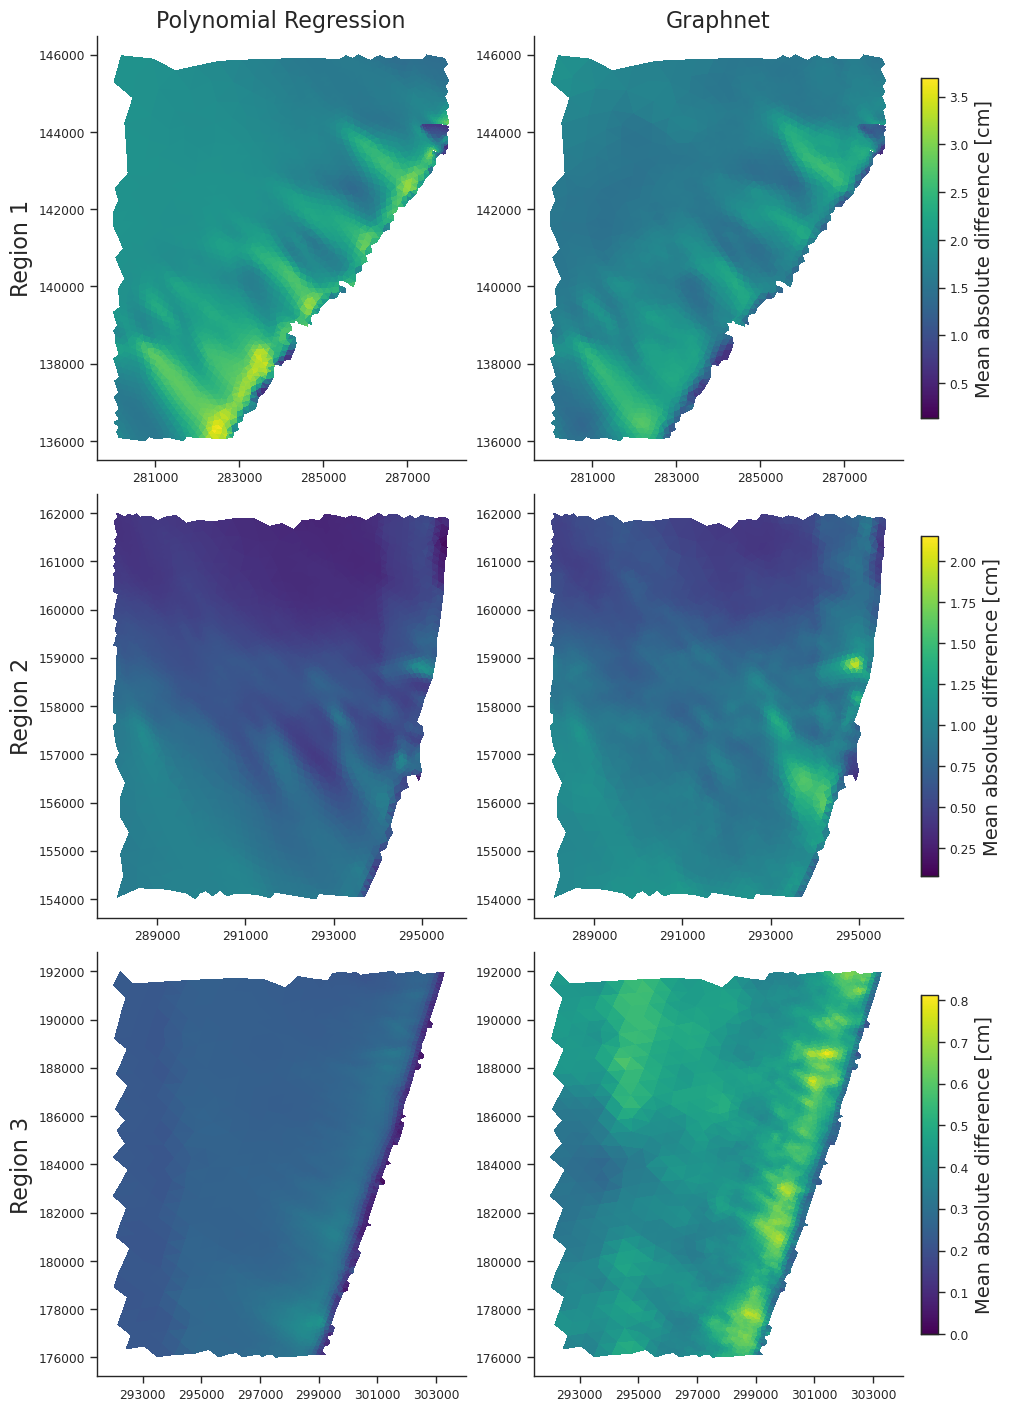

In [7]:
# Create scatter density plots for the three different regions and let each row have its own suptitle

fig, axs = plt.subplots(3, 2, figsize=(10, 14), constrained_layout=True)
# plt.subplots_adjust(right=0.9, hspace=0.1)

for idx, diff in enumerate(diffs):
    diff_lin = diffs_lin[idx]
    mesh = meshes[idx]

    vmin = np.nanmin(np.r_[diff_lin, diff])*100
    vmax = np.nanmax(np.r_[diff_lin, diff])*100

    im = mm.plot_meshed_data(diff_lin*100, mesh, ax=axs[idx, 0], vmin=vmin,
                             vmax=vmax, cmap="viridis")
    mm.plot_meshed_data(diff*100, mesh, ax=axs[idx, 1], vmin=vmin, vmax=vmax,
                        cmap="viridis")
    
    cb = fig.colorbar(im, ax=axs[idx, 1], orientation="vertical", shrink=0.8)
    cb.set_label("Mean absolute difference [cm]", fontsize=14)

    # Reduce number of ticks
    coords_min, coords_max = mesh.coords.min(axis=0), mesh.coords.max(axis=0)+2000
    xmin = int(coords_min[0]) - (int(coords_min[0]) % 1000) + 1000
    xmax = int(coords_max[0]) - (int(coords_max[0]) % 1000)
    xticks = np.arange(xmin, xmax, 2000)

    axs[idx, 0].set_xticks(xticks)
    axs[idx, 1].set_xticks(xticks)

    axs[idx, 0].set_ylabel(f"Region {nregions[idx]}", fontsize=16)
    
axs[0, 0].set_title("Polynomial Regression", fontsize=16)
axs[0, 1].set_title("Graphnet", fontsize=16)

sns.set_theme(context="paper", style="ticks")
sns.despine()


plt.savefig("plots/three-regions-error-maps.png", dpi=300, bbox_inches="tight")
plt.show()

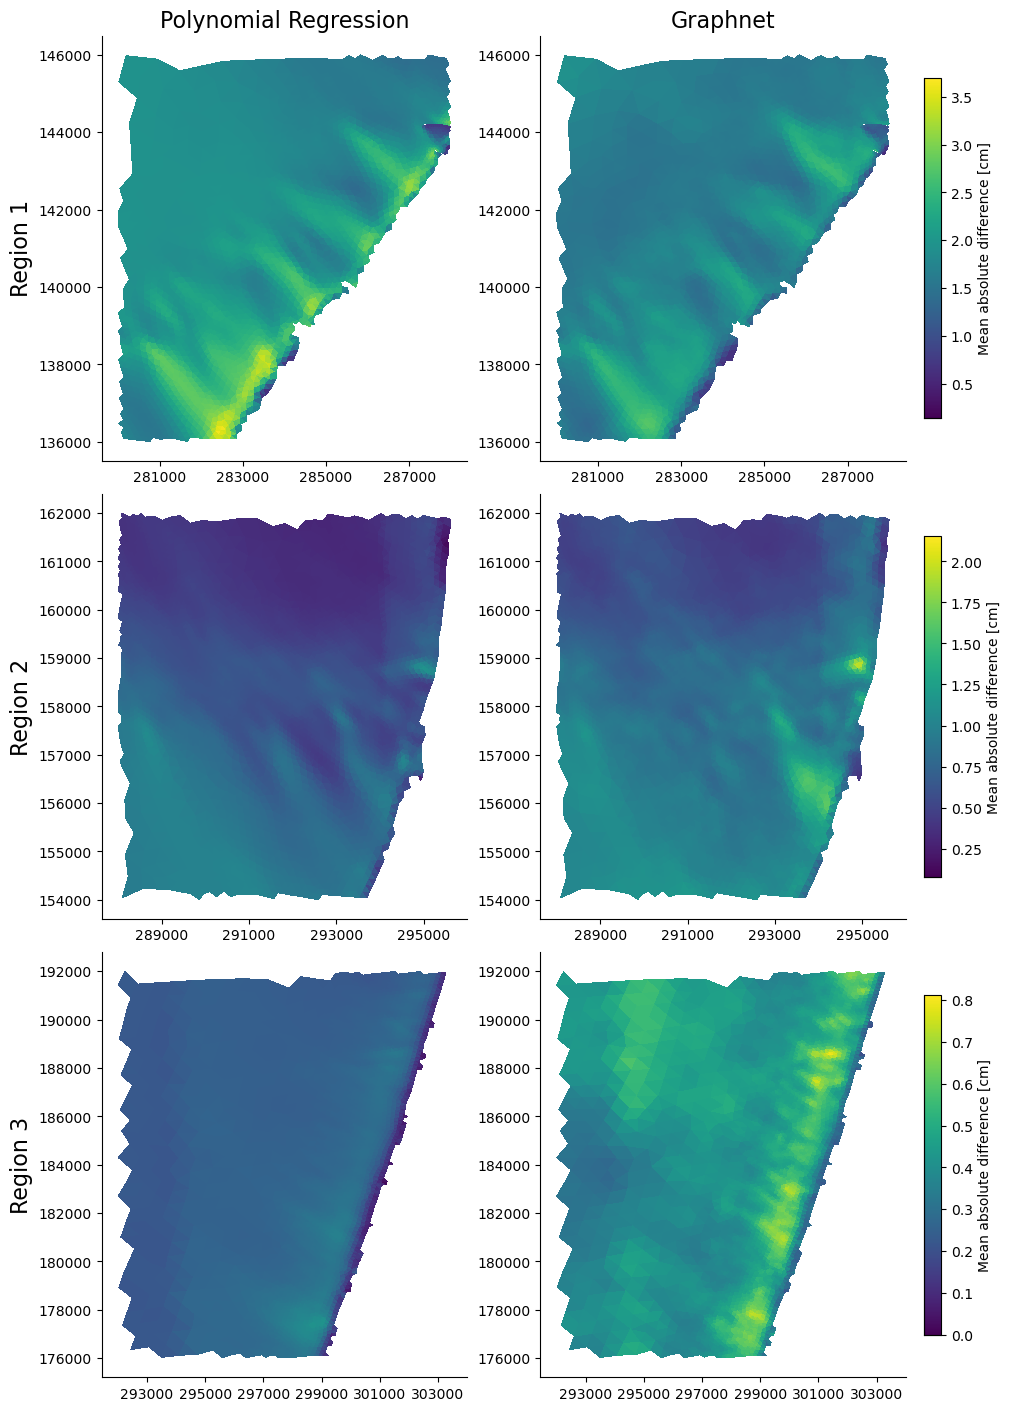

In [6]:
# Create scatter density plots for the three different regions and let each row have its own suptitle

fig, axs = plt.subplots(3, 2, figsize=(10, 14), constrained_layout=True)
# plt.subplots_adjust(right=0.9, hspace=0.1)

for idx, diff in enumerate(diffs):
    diff_lin = diffs_lin[idx]
    mesh = meshes[idx]

    vmin = np.nanmin(np.r_[diff_lin, diff])*100
    vmax = np.nanmax(np.r_[diff_lin, diff])*100

    im = mm.plot_meshed_data(diff_lin*100, mesh, ax=axs[idx, 0], vmin=vmin,
                             vmax=vmax, cmap="viridis")
    mm.plot_meshed_data(diff*100, mesh, ax=axs[idx, 1], vmin=vmin, vmax=vmax,
                        cmap="viridis")
    
    cb = fig.colorbar(im, ax=axs[idx, 1], orientation="vertical", shrink=0.8)
    cb.set_label("Mean absolute difference [cm]")

    # Reduce number of ticks
    coords_min, coords_max = mesh.coords.min(axis=0), mesh.coords.max(axis=0)+2000
    xmin = int(coords_min[0]) - (int(coords_min[0]) % 1000) + 1000
    xmax = int(coords_max[0]) - (int(coords_max[0]) % 1000)
    xticks = np.arange(xmin, xmax, 2000)

    axs[idx, 0].set_xticks(xticks)
    axs[idx, 1].set_xticks(xticks)

    axs[idx, 0].set_ylabel(f"Region {nregions[idx]}", fontsize=16)
    
axs[0, 0].set_title("Polynomial Regression", fontsize=16)
axs[0, 1].set_title("Graphnet", fontsize=16)

sns.set_theme(context="paper", style="ticks")
sns.despine()



In [10]:
mesh = meshes[0]
coords_min, coords_max = mesh.coords.min(axis=0), mesh.coords.max(axis=0)
xmin = int(coords_min[0]) - (int(coords_min[0]) % 5000)
xmax = int(coords_max[0]) - (int(coords_max[0]) % 5000)

In [11]:
xmin

280000

In [12]:
xmax

285000

In [34]:
coords_max

array([292005.405693, 176007.119869])